# Configurações

In [2]:
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
from PIL import Image
import timeit
import time

In [3]:
import cupy as cp

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
cp.get_default_memory_pool().free_all_blocks()

In [6]:
# Verificar versão do CuPy
print(cp.__version__)

# Verificar se CuPy pode detectar a GPU
print(cp.cuda.runtime.getDeviceCount())

# Definir o dispositivo GPU
cp.cuda.Device(0).use()

# Verificar se CuPy está usando a GPU
array = cp.array([1, 2, 3])
print(array.device)  # Deve exibir algo como "<CUDA Device 0>

13.2.0
1
<CUDA Device 0>


#### Função auxiliar

In [177]:
def plot_speedup(x_values, ratios, title):
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, ratios, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of faces')
    plt.ylabel('Speedup')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [181]:
def display_image(image, title='Image'):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Carregando Dataset

In [10]:
def unzip(zip_file=None, extract_to="extracted_images"):
    try:
        if os.path.exists(extract_to):
            print(f"The directory '{extract_to}' already exists. Extraction skipped.")
            return
            
        with zipfile.ZipFile(zip_file, 'r') as z:
            # Cria o diretório de extração se ele não existir
            if not os.path.exists(extract_to):
                os.makedirs(extract_to)
            
            z.extractall(extract_to)
            print("Extracted all to", extract_to)
    except zipfile.BadZipFile:
        print("Invalid file")

In [11]:
unzip(zip_file='./attdataface.zip', extract_to='./kaggle/input/att-database-of-faces/')

The directory './kaggle/input/att-database-of-faces/' already exists. Extraction skipped.


In [12]:
paths = ["./kaggle/input/att-database-of-faces/s" + str(i) for i in range(1, 41)]
cnt = 0
Data = np.zeros((400, 10304))
labels = np.zeros((400, 1))
for i in range(40):
    labels[i * 10 : (i + 1) * 10] = i + 1
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img.flatten()
        Data[cnt] = np_img
        cnt += 1

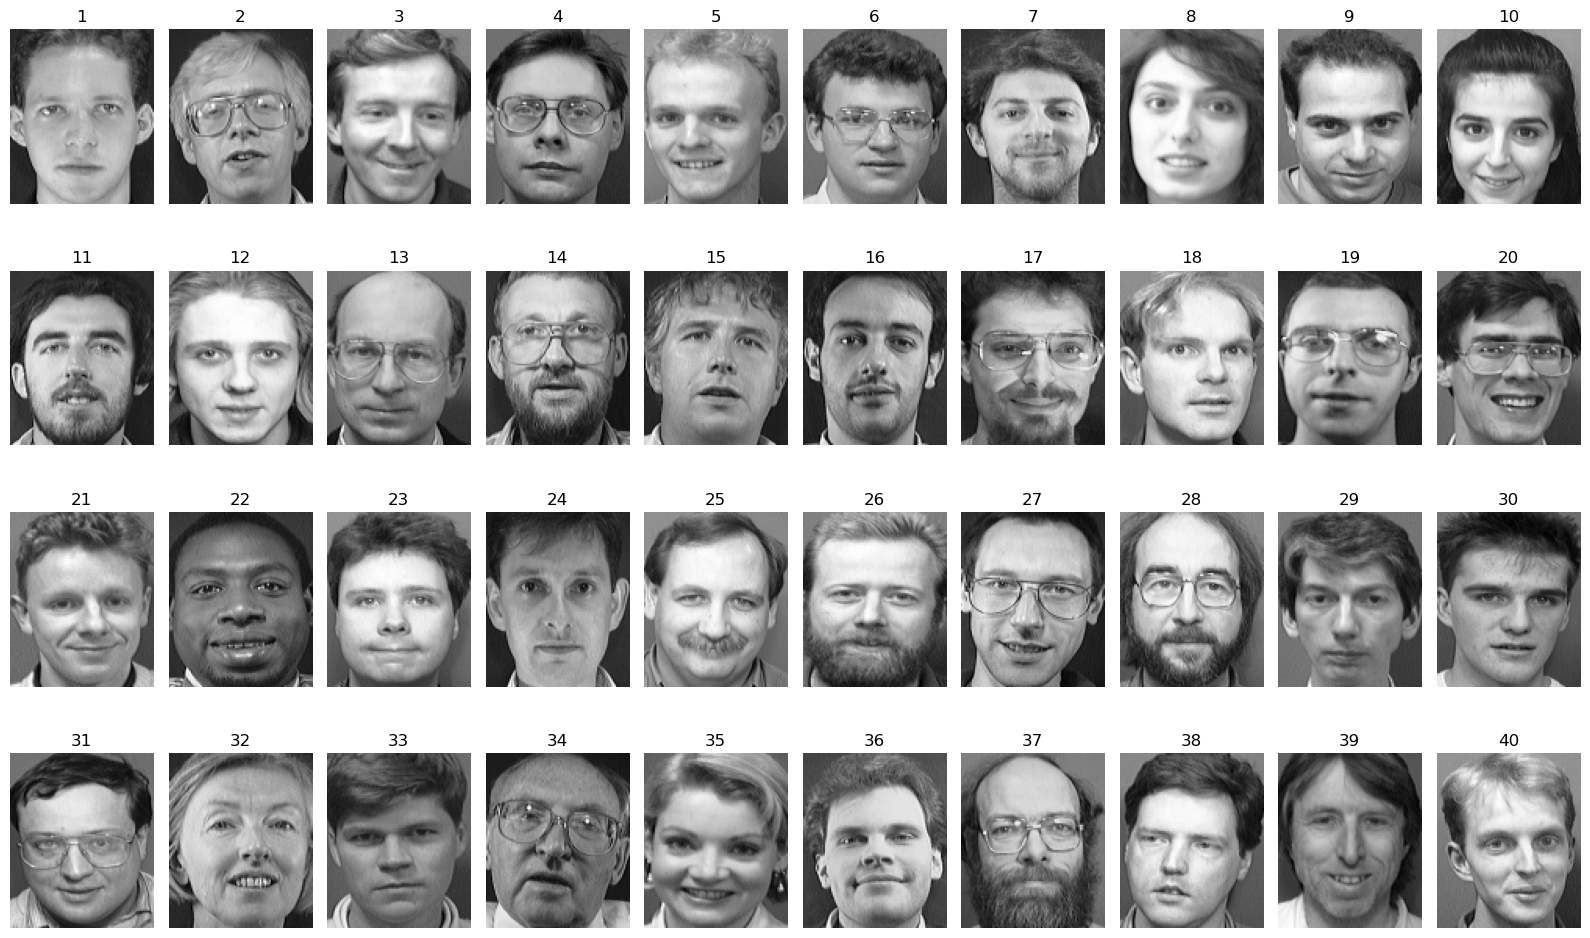

In [13]:
image_height = 112
image_width = 92

fig, axs = plt.subplots(4, 10, figsize=(16, 10))

# Flatten the array of axes
axs = axs.ravel()

for i in range(40):
    image_array = np.reshape(Data[(i) * 10], (image_height, image_width))
    axs[i].imshow(image_array, cmap="gray")
    axs[i].set_title(i + 1)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

# PCA

 1. Normalização
  2. Cálculo da Face Média
  3. Cálculo da diferença
  4. Transposição da matriz
  5. Cálculo da matriz reduzida
  6. 

In [16]:
# Dividindo o array Data em partes acumulativas
num_parts = 10
part_size = 40
parts = []

for i in range(num_parts):
    end_idx = (i + 1) * part_size
    parts.append(Data[:end_idx])
    
# Lista para armazenar as razões entre os tempos de execução
ratios = []
x_values = []

## 1. Normalização

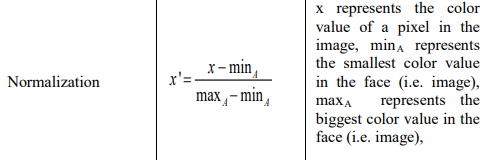

#### 1.1 Normalização Sequencial

In [20]:
def normalizeS(image_array):
    
    image_array = image_array.astype(np.float32)
    
    # inicializa xmin e xmax
    xmin = float('inf')
    xmax = float('-inf')

    for row in image_array:
        for pixel in row:
            if pixel < xmin:
                xmin = pixel
            if pixel > xmax:
                xmax = pixel
    
    normalized_array = (image_array - xmin) / (xmax - xmin)
    
    # Converte o array normalizado de volta para a faixa de 0-255
    normalized_array = (normalized_array * 255).astype(np.uint8)
    
    return normalized_array

In [21]:
#%%timeit
#normalize_s(Data)

#### 1.2 Normalização Paralela

In [117]:
# rawKernel
kernel_code = '''
extern "C" __global__
void normalize_kernel(float* image, float xmin, float xmax, float* result, int size) {
    int idx = blockDim.x * blockIdx.x + threadIdx.x;
    if (idx < size) {
        result[idx] = (image[idx] - xmin) / (xmax - xmin) * 255.0;
    }
}
'''

normalize_kernel = cp.RawKernel(kernel_code, 'normalize_kernel')

def normalizeP(image_array):
    
    image_array = cp.asarray(image_array, dtype=cp.float32)
    
    xmin, xmax = cp.min(image_array), cp.max(image_array)

    normalized_array = cp.empty_like(image_array)

    size = image_array.size

     # std configs
    block_size = 256
    grid_size = (size + block_size - 1) // block_size
    block_dim = (block_size,)
    grid_dim = (grid_size,)

    normalize_kernel(grid_dim, block_dim, (image_array, xmin, xmax, normalized_array, size))

    return normalized_array.astype(cp.uint8)

In [24]:
#%%timeit
#normalize_p(Data)

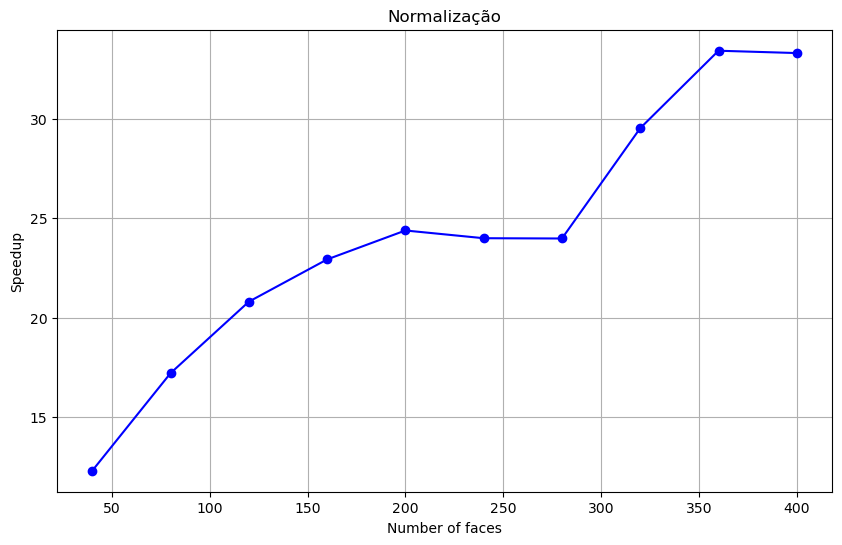

In [40]:
for i in range(num_parts):
    data_part = parts[i]
    
    timeS = timeit.timeit(lambda: normalizeS(data_part), number=100)
    timeP = timeit.timeit(lambda: normalizeP(data_part), number=100)
   
    ratio = timeS / timeP

    ratios.append(ratio)
    x_values.append((i + 1) * part_size)

plot_speedup(x_values, ratios, "Normalização")

## 2. Cálculo da Face média

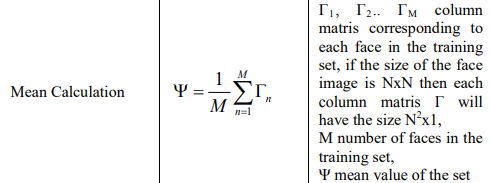

#### 2.1 Cálculo da Média Sequencial

In [137]:
def media_s(arr):
    soma = 0
    contagem = 0
    for elemento in arr:
        soma += elemento
        contagem += 1
    media = soma / contagem
    return media

In [188]:
%%timeit
digs = media_s(Data)
print(Data)

[[ 48.  49.  45. ...  47.  46.  46.]
 [ 34.  34.  33. ...  37.  40.  33.]
 [ 60.  60.  62. ...  32.  34.  34.]
 ...
 [129. 127. 133. ...  93.  93.  93.]
 [125. 119. 124. ...  36.  39.  40.]
 [119. 120. 120. ...  89.  94.  85.]]
[[ 48.  49.  45. ...  47.  46.  46.]
 [ 34.  34.  33. ...  37.  40.  33.]
 [ 60.  60.  62. ...  32.  34.  34.]
 ...
 [129. 127. 133. ...  93.  93.  93.]
 [125. 119. 124. ...  36.  39.  40.]
 [119. 120. 120. ...  89.  94.  85.]]
[[ 48.  49.  45. ...  47.  46.  46.]
 [ 34.  34.  33. ...  37.  40.  33.]
 [ 60.  60.  62. ...  32.  34.  34.]
 ...
 [129. 127. 133. ...  93.  93.  93.]
 [125. 119. 124. ...  36.  39.  40.]
 [119. 120. 120. ...  89.  94.  85.]]
[[ 48.  49.  45. ...  47.  46.  46.]
 [ 34.  34.  33. ...  37.  40.  33.]
 [ 60.  60.  62. ...  32.  34.  34.]
 ...
 [129. 127. 133. ...  93.  93.  93.]
 [125. 119. 124. ...  36.  39.  40.]
 [119. 120. 120. ...  89.  94.  85.]]
[[ 48.  49.  45. ...  47.  46.  46.]
 [ 34.  34.  33. ...  37.  40.  33.]
 [ 60.  60.  6

#### 2.2 Cálculo da Média Paralelo

In [171]:
kernel_code = r'''
extern "C" __global__
void sum_reduce(const float* x, float* y, int n) {
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  if (i < n) {
    atomicAdd(y, x[i]);
  }
}
'''

# Compilação do kernel
module = cp.RawKernel(kernel_code, name='sum_reduce')

def media_p(arr):
    arr_gpu = cp.asarray(arr, dtype=cp.float32)

    # inicializando para armazenar
    result_gpu = cp.zeros(1, dtype=cp.float32)

    # std configs
    block_size = 256
    grid_size = (arr_gpu.size + block_size - 1) // block_size
    block_dim = (block_size,)
    grid_dim = (grid_size,)

    module(grid_dim, block_dim, (arr_gpu, result_gpu, arr_gpu.size))

    result = cp.asnumpy(result_gpu)

    media = result[0] / arr_gpu.size

    return media

In [186]:
#%%timeit
digs = media_p(Data)
print(Data)

[[ 48.  49.  45. ...  47.  46.  46.]
 [ 34.  34.  33. ...  37.  40.  33.]
 [ 60.  60.  62. ...  32.  34.  34.]
 ...
 [129. 127. 133. ...  93.  93.  93.]
 [125. 119. 124. ...  36.  39.  40.]
 [119. 120. 120. ...  89.  94.  85.]]
[[ 48.  49.  45. ...  47.  46.  46.]
 [ 34.  34.  33. ...  37.  40.  33.]
 [ 60.  60.  62. ...  32.  34.  34.]
 ...
 [129. 127. 133. ...  93.  93.  93.]
 [125. 119. 124. ...  36.  39.  40.]
 [119. 120. 120. ...  89.  94.  85.]]
[[ 48.  49.  45. ...  47.  46.  46.]
 [ 34.  34.  33. ...  37.  40.  33.]
 [ 60.  60.  62. ...  32.  34.  34.]
 ...
 [129. 127. 133. ...  93.  93.  93.]
 [125. 119. 124. ...  36.  39.  40.]
 [119. 120. 120. ...  89.  94.  85.]]
[[ 48.  49.  45. ...  47.  46.  46.]
 [ 34.  34.  33. ...  37.  40.  33.]
 [ 60.  60.  62. ...  32.  34.  34.]
 ...
 [129. 127. 133. ...  93.  93.  93.]
 [125. 119. 124. ...  36.  39.  40.]
 [119. 120. 120. ...  89.  94.  85.]]
[[ 48.  49.  45. ...  47.  46.  46.]
 [ 34.  34.  33. ...  37.  40.  33.]
 [ 60.  60.  6

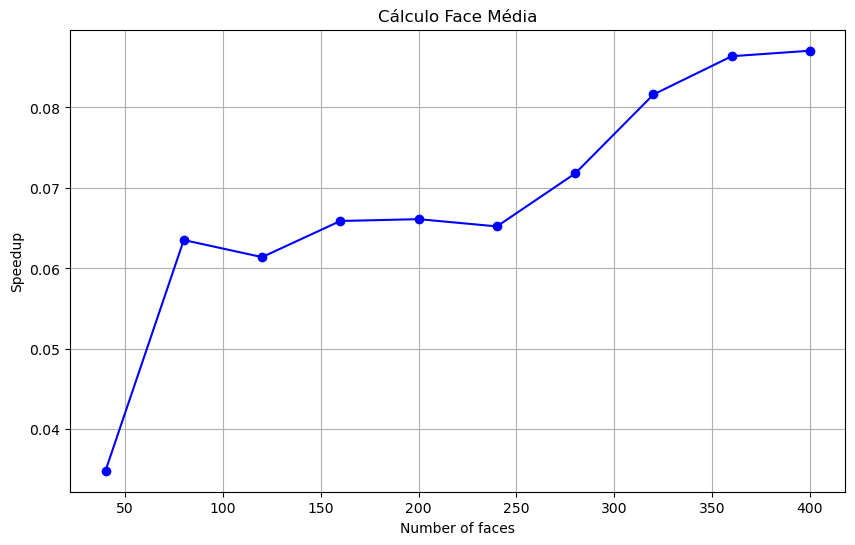

In [185]:
# armazenar as razões entre os tempos de execução
ratios = []
x_values = []

# Medindo o tempo de execução para cada parte
for i in range(num_parts):
    data_part = parts[i]
    
    # Medindo o tempo de execução de func1 e func2
    timeS = timeit.timeit(lambda: media_s(data_part), number=100)
    timeP = timeit.timeit(lambda: media_p(data_part), number=100)
    
    ratio = timeS / timeP

    # Armazenando os resultados
    ratios.append(ratio)
    x_values.append((i + 1) * part_size)

plot_speedup(x_values, ratios, "Cálculo Face Média")

(10304,)


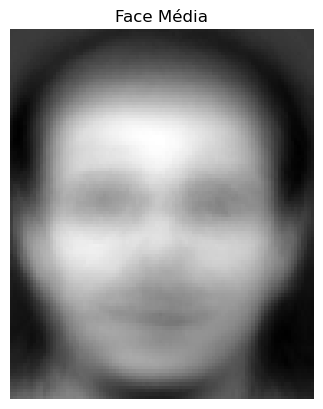

In [266]:
# calcular a face média utilizando media_s
mean_face_vector = np.apply_along_axis(media_s, 0, Data)
mean_face_image = mean_face_vector.reshape(112, 92)  # Redimensiona para o formato original

mean_face_vectors_parts = []

sizes = [40, 80, 120, 160, 200, 240, 280, 320, 360, 400]

# Criação das partes
for size in sizes:
    # Repete mean_face_vector `size` vezes ao longo da primeira dimensão
    part = np.tile(mean_face_vector, (size, 1))
    mean_face_vectors_parts.append(part)

print(mean_face_vector.shape)

# chama a função auxiliar
display_image(mean_face_image, title='Face Média')

## 3. Cálculo da Diferença entre instância e face média

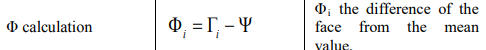

#### 3.1 Cálculo da Diferença Sequencial

In [244]:
def dif_s(array1, array2):

    if array1.shape != array2.shape:
         raise ValueError("dif tamanho.")

    diff = np.zeros_like(array1)

    for idx in np.ndindex(array1.shape):
        diff[idx] = array1[idx] - array2[idx]

    return diff

In [246]:
# Gerar vetores de exemplo
np.random.seed(0)  # Para reproducibilidade
vetor1 = np.random.rand(1000).astype(np.float32)
vetor2 = np.random.rand(1000).astype(np.float32)

In [248]:
%%timeit
dif_s(vetor1, vetor2)

492 µs ± 16 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### 3.2 Cálculo da Diferença Paralelo

In [249]:
kernel_code = r'''
extern "C" __global__
void vector_diff(const float* x, const float* y, float* z, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        z[i] = x[i] - y[i];
    }
}
'''

module = cp.RawKernel(code=kernel_code, name='vector_diff')

def dif_p(vetor1, vetor2):
    vetor1_gpu = cp.asarray(vetor1, dtype=cp.float32)
    vetor2_gpu = cp.asarray(vetor2, dtype=cp.float32)
    
    if vetor1_gpu.size != vetor2_gpu.size:
        raise ValueError("dif tamanho.")
    
    resultado_gpu = cp.zeros_like(vetor1_gpu, dtype=cp.float32)
    
    # std configs
    block_size = 256
    grid_size = (vetor1_gpu.size + block_size - 1) // block_size
    block_dim = (block_size,)
    grid_dim = (grid_size,)
    
    module(grid_dim, block_dim, (vetor1_gpu, vetor2_gpu, resultado_gpu, vetor1_gpu.size))
    
    # transferindo o resultado de volta para a CPU
    resultado = cp.asnumpy(resultado_gpu)
    
    return resultado

In [250]:
%%timeit
dif_p(vetor1, vetor2)

211 µs ± 2.32 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [264]:
print(parts[9].shape)

(400, 10304)


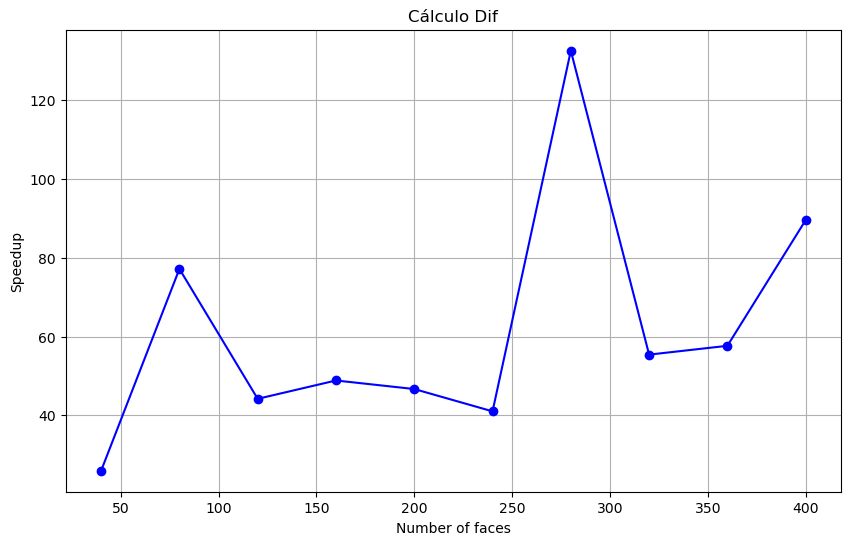

In [292]:
# armazenar as razões entre os tempos de execução
ratios = []
x_values = []

# Medindo o tempo de execução para cada parte
for i in range(num_parts):
    data_part = parts[i]
    mean_part = mean_face_vectors_parts[i]

    # Medindo o tempo de execução de func1 e func2
    timeS = timeit.timeit(lambda: dif_s(data_part, mean_part), number=10)
    timeP = timeit.timeit(lambda: dif_p(data_part, mean_part), number=10)
    
    ratio = timeS / timeP

    # Armazenando os resultados
    ratios.append(ratio)
    x_values.append((i + 1) * part_size)

plot_speedup(x_values, ratios, "Cálculo Dif")

In [322]:
phi_vector = Data - mean_face_vector
print(phi_vector.shape)

(400, 10304)


## 4. Transposição da Matriz de Diferenças

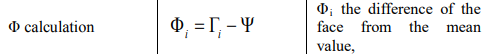

#### 4.1 Transposição Sequencial

In [324]:
def transpose_s(matrix):

    num_rows = len(matrix)
    num_cols = len(matrix[0])

    # create transpose matrix
    transposed_matrix = [[0] * num_rows for _ in range(num_cols)]

    for i in range(num_rows):
        for j in range(num_cols):
            transposed_matrix[j][i] = matrix[i][j]

    return transposed_matrix

In [326]:
%%timeit
transpose_s(phi_vector)

799 ms ± 9.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 4.2 Transposição Paralela

In [328]:
kernel_code = r'''
extern "C" __global__
void transpose(const float* in, float* out, int rows, int cols) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < rows && y < cols) {
        out[y * rows + x] = in[x * cols + y];
    }
}
'''

module = cp.RawKernel(kernel_code, name='transpose')

def transpose_p(matrix):
    matrix_gpu = cp.asarray(matrix, dtype=cp.float32)

    rows, cols = matrix_gpu.shape

    transposed_matrix_gpu = cp.zeros((cols, rows), dtype=cp.float32)

    # std configs
    block_size = 256
    block_dim = (block_size, 1)  # Bloco de 256 threads em uma dimensão
    grid_size = (rows + block_size - 1) // block_size
    grid_dim = (grid_size, cols) 

    module(grid_dim, block_dim, (matrix_gpu, transposed_matrix_gpu, rows, cols))

    transposed_matrix = cp.asnumpy(transposed_matrix_gpu)

    return transposed_matrix

In [330]:
#%%timeit
#transpose_p(phi_vector)

12.9 ms ± 627 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


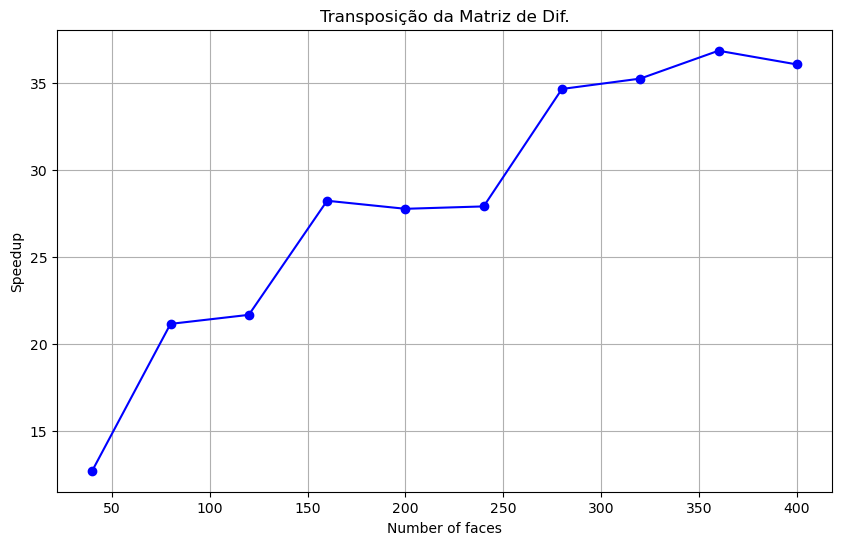

In [346]:
# armazenar as razões entre os tempos de execução
ratios = []
x_values = []

# Medindo o tempo de execução para cada parte
for i in range(num_parts):
    data_part = parts[i]
    
    timeS = timeit.timeit(lambda: transpose_s(data_part), number=20)
    timeP = timeit.timeit(lambda: transpose_p(data_part), number=20)
    
    ratio = timeS / timeP

    # Armazenando os resultados
    ratios.append(ratio)
    x_values.append((i + 1) * part_size)

plot_speedup(x_values, ratios, "Transposição da Matriz de Dif.")